In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torchvision

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Step 1: Load and Preprocess the Data
class FER2013Dataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data = pd.read_csv(csv_file)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = np.fromstring(self.data.iloc[idx, 1], dtype=int, sep=' ').reshape(48, 48).astype(np.uint8)
        label = int(self.data.iloc[idx, 0])

        if self.transform:
            image = self.transform(image)

        return image, label

# Normalization only
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

In [17]:

# Load datasets
csv_file = 'data/fer2013/fer2013.csv'  # Replace with the path to your FER2013 CSV file
train_dataset = FER2013Dataset(csv_file=csv_file, transform=transform)

# Split data into train, validation, and test sets
train_data, val_data, test_data = torch.utils.data.random_split(train_dataset, [28709, 3589, 3589])
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

# Step 2: Define the CNN Model with nn.Sequential
class EmotionCNN(nn.Module):
    def __init__(self):
        super(EmotionCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(256 * 3 * 3, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 7)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(-1, 256 * 3 * 3)
        x = self.classifier(x)
        return x

model = EmotionCNN().to(device)

In [18]:
# Step 3: Train the Model
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')
    
    # Validation
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    print(f'Validation Accuracy: {100 * correct / total:.2f}%')

Epoch [1/5], Loss: 1.6722
Validation Accuracy: 42.94%
Epoch [2/5], Loss: 1.3754
Validation Accuracy: 50.32%
Epoch [3/5], Loss: 1.2287
Validation Accuracy: 53.55%
Epoch [4/5], Loss: 1.1241
Validation Accuracy: 55.03%
Epoch [5/5], Loss: 1.0289
Validation Accuracy: 56.78%


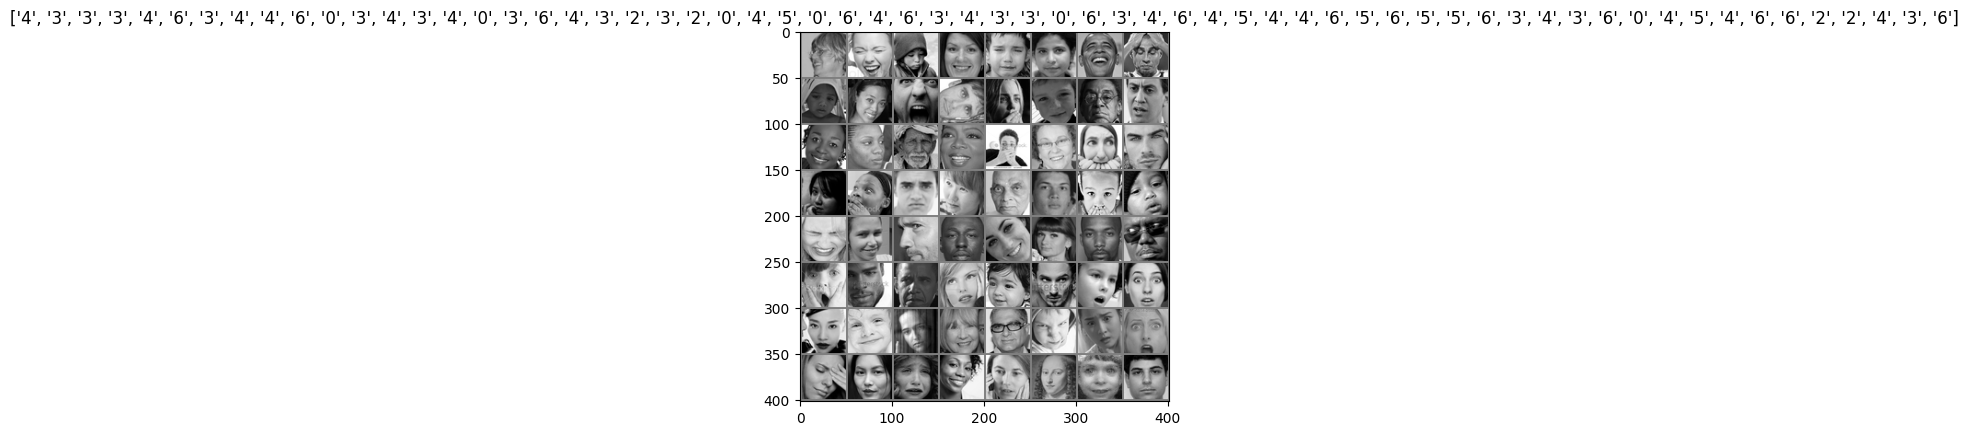

GroundTruth:  ['3', '2', '4', '3', '4', '6', '3', '2', '4', '3', '0', '4', '2', '6', '6', '2', '3', '4', '6', '3', '5', '3', '2', '0', '2', '5', '1', '2', '6', '6', '2', '6', '2', '3', '0', '6', '3', '6', '6', '2', '5', '6', '2', '0', '3', '6', '5', '5', '6', '3', '4', '3', '6', '0', '2', '2', '4', '6', '4', '3', '2', '6', '5', '6']
Accuracy of the network on the test images: 55.50292560601839%


In [19]:
# Step 4: Evaluate the Model
model.eval()
all_labels = []
all_preds = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

# Step 5: Plot Sample Predictions
def imshow(img, title):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)), cmap='gray')
    plt.title(title)
    plt.show()

# Get some random test images
dataiter = iter(test_loader)
images, labels = next(dataiter)
images, labels = images.to(device), labels.to(device)
outputs = model(images)
_, predicted = torch.max(outputs, 1)

# Show images and predicted labels
imshow(torchvision.utils.make_grid(images.cpu(), nrow=8), title=[str(x.item()) for x in predicted])
print('GroundTruth: ', [str(x.item()) for x in labels])

#print accuracy
correct = 0
total = 0
for images, labels in test_loader:
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the test images: {100 * correct / total}%')